In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from models.folds import Fold, SoftFold
from models.model_bank import DynamicOrigami
from models.training import train, NoamScheduler, load_data
from torch.utils.data import Dataset, DataLoader



# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


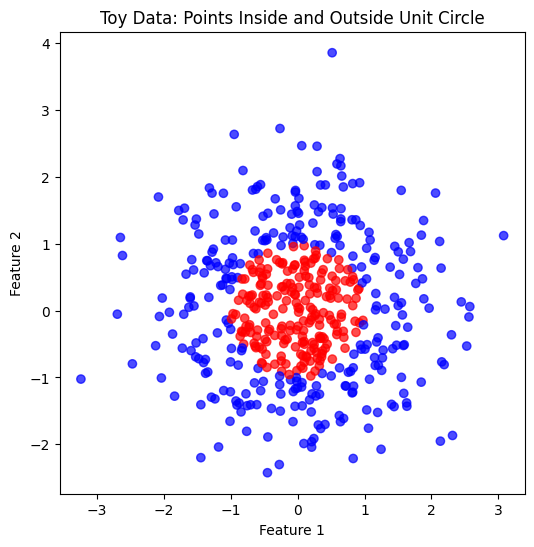

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 500

width = 2
# Generate random points in 2D space
X = np.random.randn(n_samples, width)

# Labels: Points inside the unit circle are labeled True (1), others False (0)
y = (np.linalg.norm(X, axis=1) < 1).astype(int)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Toy Data: Points Inside and Outside Unit Circle')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.show()

In [4]:
# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 30
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)



In [5]:
print(xorX.shape, xorY.shape)

torch.Size([900, 2]) torch.Size([900])


In [9]:
test_case_x = xorX
test_case_y = xorY

train_X, train_y, val_X, val_y = xorX, xorY, xorX, xorY

architecture = [{'type': 'SoftFold', 'params': {'width': 2, 'has_stretch': True}},
                {'type': 'SoftFold', 'params': {'width': 2, 'has_stretch': True}},]

model = DynamicOrigami(architecture, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=3)
train_loader = load_data(test_case_x, test_case_y, batch_size=32, shuffle=True)
val_loader = load_data(val_X, val_y, batch_size=32, shuffle=False)
scheduler = NoamScheduler(optimizer, warmup_steps=100, model_size=64)

train_losses, val_losses, train_accuracies, val_accuracies,learning_rates = train(model, optimizer, train_loader,val_loader, epochs=500, lr_schedule=scheduler)

/Users/jeddybennett/Documents/FoldAndCutNetworks/models/training.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x_data, dtype=torch.float32)  # Specify float32 for model compatibility
/Users/jeddybennett/Documents/FoldAndCutNetworks/models/training.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.long)     # Specify long for classification labels


Working Device: cpu


epoch:500/500, batch: 29/29, loss:0.0000: 100%|██████████| 14500/14500 [01:37<00:00, 148.69it/s]


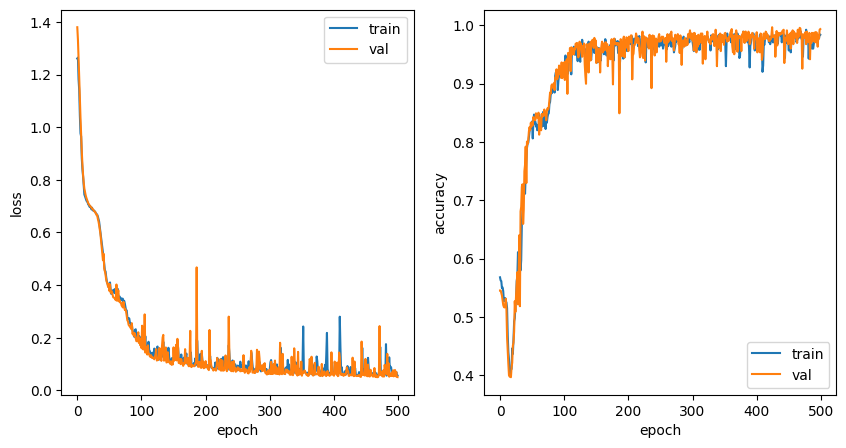

In [10]:
# plot the losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


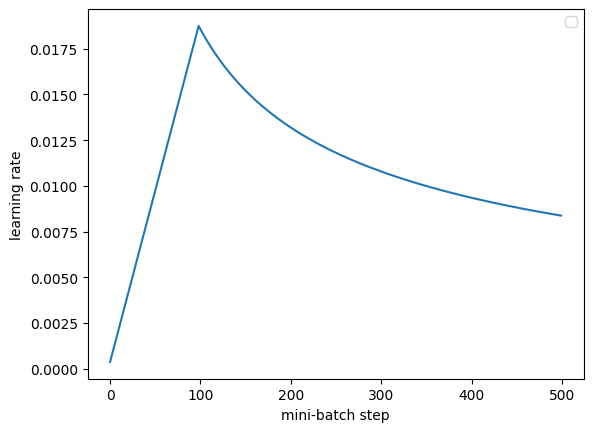

In [11]:
# plot the learning rates
plt.plot(np.arange(len(learning_rates)), learning_rates)
plt.xlabel('mini-batch step')
plt.ylabel('learning rate')
plt.legend()
plt.show()

In [30]:
architecture = [{'type': 'SoftFold', 'params': {'width': 64, 'has_stretch': True}},
                {'type': 'SoftFold', 'params': {'width': 70, 'has_stretch': True}},
                {'type': 'SoftFold', 'params': {'width': 80, 'has_stretch': True}},
                {'type': 'SoftFold', 'params': {'width': 90, 'has_stretch': True}},]


# import small digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


model = DynamicOrigami(architecture,10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
train_loader = load_data(X_train, y_train, batch_size=32, shuffle=True)
val_loader = load_data(X_val, y_val, batch_size=32, shuffle=True)
test_loader = load_data(X_test, y_test, batch_size=32, shuffle=True)

scheduler = NoamScheduler(optimizer, warmup_steps=50, model_size=64)
train_losses, val_losses, train_accuracies, val_accuracies,learning_rates = train(model, optimizer, train_loader,val_loader, epochs=300, lr_schedule=scheduler)


Working Device: cpu


epoch:300/300, batch: 36/36, loss:0.0004: 100%|██████████| 10800/10800 [01:25<00:00, 126.04it/s]


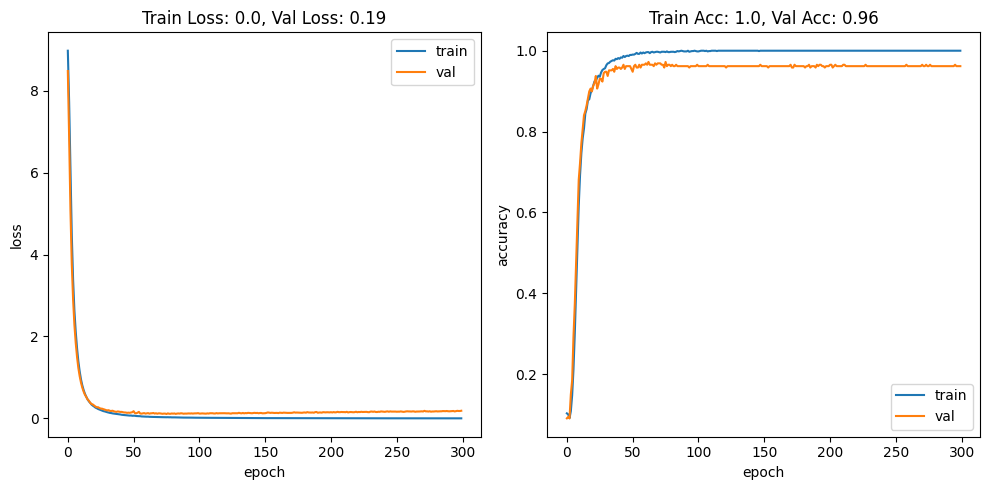

In [33]:
# plot the losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Train Loss: {round(train_losses[-1],2)}, Val Loss: {round(val_losses[-1],2)}')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f'Train Acc: {round(train_accuracies[-1],2)}, Val Acc: {round(val_accuracies[-1],2)}')
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


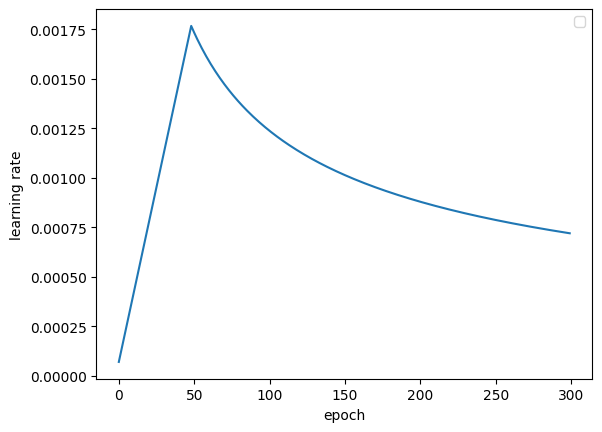

In [34]:
# plot the learning rates
plt.plot(np.arange(len(learning_rates)), learning_rates)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.legend()
plt.show()

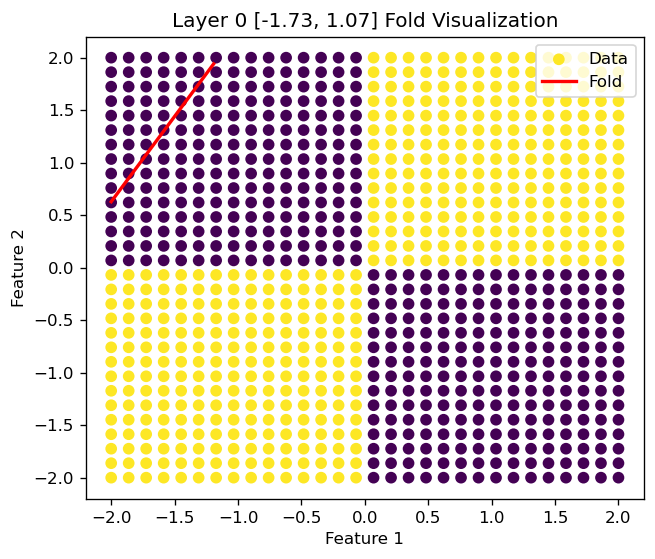

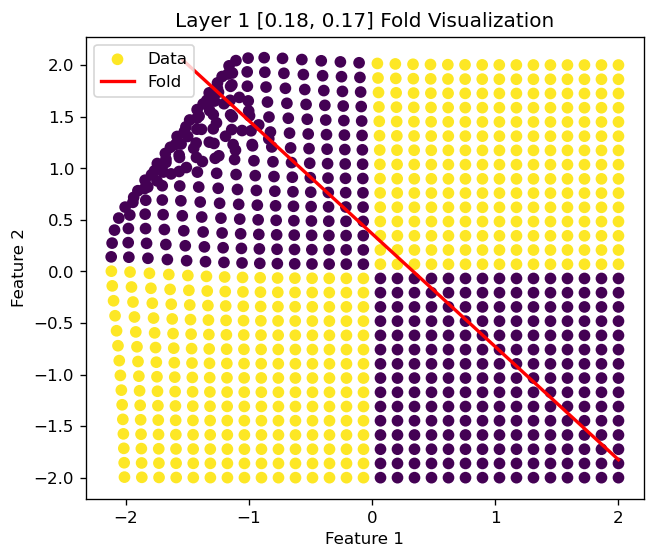

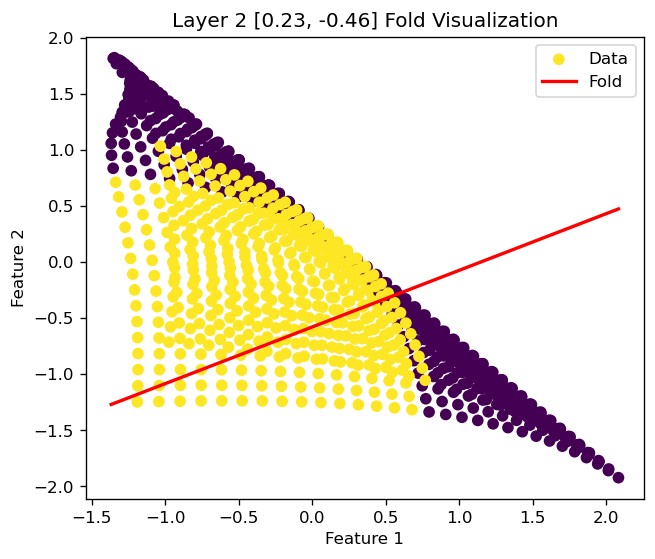

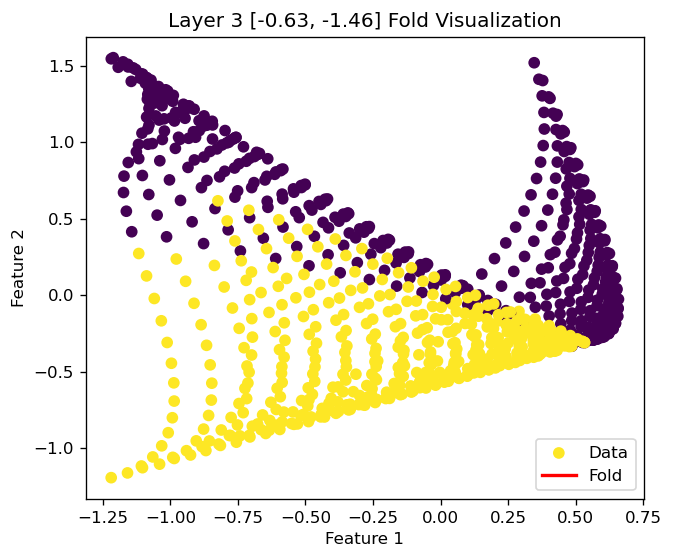

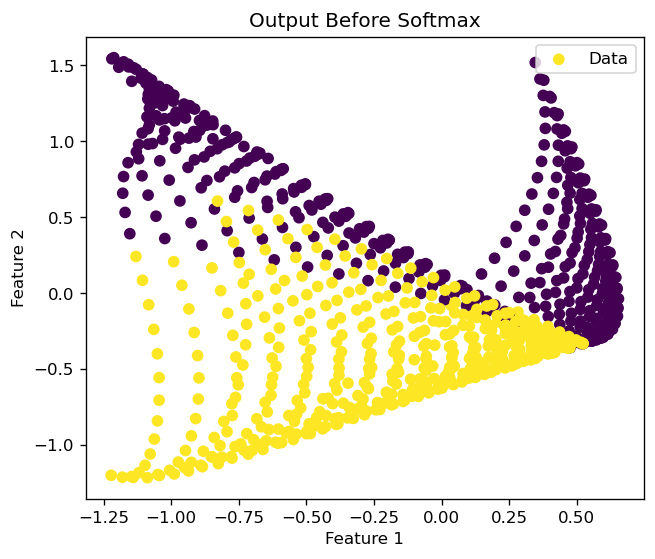

In [8]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
# reimport("from vis_helpers import *", globals())
for layer_index in range(layers+1):
    plot_folds(test, layer_index=layer_index, use_plotly=False)

In [9]:
max_score, best_folds = create_landscape(test, landscape_type="Loss", density=61, verbose=1)

Loss Layer 0: 100%|██████████| 3721/3721 [00:03<00:00, 1113.13it/s]


Loss Layer 1: 100%|██████████| 3721/3721 [00:03<00:00, 1104.08it/s]


Loss Layer 2: 100%|██████████| 3721/3721 [00:03<00:00, 1125.53it/s]


Loss Layer 3: 100%|██████████| 3721/3721 [00:03<00:00, 1156.09it/s]


In [10]:
gradient_landscape(test, density = 100, invert = True)

Gradient Layer 0:   0%|          | 0/10000 [00:00<?, ?it/s]

Gradient Layer 0: 100%|██████████| 10000/10000 [00:30<00:00, 328.53it/s]


Gradient Layer 1: 100%|██████████| 10000/10000 [00:30<00:00, 333.02it/s]


Gradient Layer 2: 100%|██████████| 10000/10000 [00:29<00:00, 339.68it/s]


Gradient Layer 3:  45%|████▍     | 4496/10000 [00:14<00:17, 319.43it/s]


KeyboardInterrupt: 